# # Using Kmeans++

# Importing libraries 

In [34]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Loading data

In [35]:
transactions = pd.read_csv("Transactions.csv")
customers = pd.read_csv("Customers.csv")


# Doing some feature engineering

In [36]:
data = pd.merge(transactions, customers, on="CustomerID")
data['Recency'] = (pd.to_datetime('today') - pd.to_datetime(data['TransactionDate'])).dt.days

In [37]:
customer_data = data.groupby('CustomerID').agg({
    'Recency': 'mean',
    'TransactionID': 'count',
    'TotalValue': 'sum',
    'Region': 'first'
}).reset_index()

In [38]:
customer_data.rename(columns={'TransactionID': 'Frequency', 'TotalValue': 'Monetary'}, inplace=True)

# Encoding

In [39]:
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

In [40]:
customer_data_for_clustering = customer_data.drop(columns=['CustomerID'])

# Scaling

In [41]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(customer_data_for_clustering)

# PCA

In [42]:
pca = PCA(n_components=0.95)  
pca_data = pca.fit_transform(scaled_data)


# Kmeans

In [43]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)  # Adjust n_clusters as needed
customer_data['Cluster'] = kmeans.fit_predict(pca_data)


C:\Users\tanuj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# Davies-Bouldin Index

In [44]:
db_index = davies_bouldin_score(pca_data, customer_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.4f}')

Davies-Bouldin Index: 0.3662


# Silhouette Score

In [45]:
sil_score = silhouette_score(pca_data, customer_data['Cluster'])
print(f'Silhouette Score: {sil_score:.4f}')

Silhouette Score: 0.7049


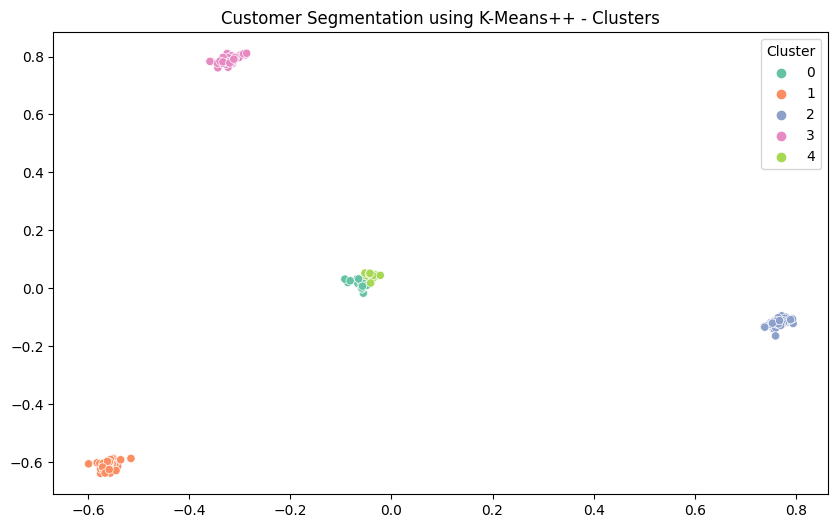

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=customer_data['Cluster'], palette='Set2')
plt.title('Customer Segmentation using K-Means++ - Clusters')
plt.show()

# Cluster characteristics

In [47]:
print(customer_data.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std']
}))

            Recency            Frequency               Monetary             
               mean        std      mean       std         mean          std
Cluster                                                                     
0        209.656410  79.978789  3.192308  1.296741  2124.869231   909.341032
1        217.576659  57.720563  4.680000  1.878341  3325.092600  1892.626955
2        209.141310  45.680344  5.152542  1.945938  3717.840000  1852.932532
3        237.884936  48.018808  5.304348  2.511038  3311.160870  1701.181711
4        226.504343  42.150907  7.500000  1.339447  5379.353889  1110.590421


# ## Using Dbscan

In [48]:
from sklearn.cluster import DBSCAN

In [49]:
dbscan = DBSCAN(eps=0.3, min_samples=5) 
customer_data['Cluster'] = dbscan.fit_predict(pca_data)


# Davies-Bouldin Index

In [50]:
valid_clusters = customer_data[customer_data['Cluster'] != -1]
db_index = davies_bouldin_score(pca_data[valid_clusters.index], valid_clusters['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.4f}')

Davies-Bouldin Index: 0.4566


# Silhouette Score

In [51]:
sil_score = silhouette_score(pca_data[valid_clusters.index], valid_clusters['Cluster'])
print(f'Silhouette Score: {sil_score:.4f}')

Silhouette Score: 0.7242


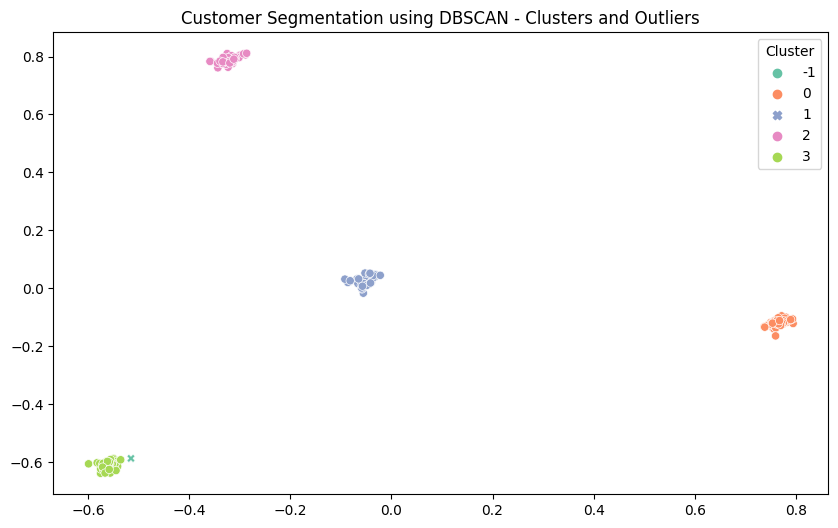

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=customer_data['Cluster'], palette='Set2', style=customer_data['Cluster'] == -1, markers=["o", "X"])
plt.title(f'Customer Segmentation using DBSCAN - Clusters and Outliers')
plt.show()

# Cluster characteristics

In [53]:
print(customer_data.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std']
}))

            Recency             Frequency                Monetary             
               mean        std       mean       std          mean          std
Cluster                                                                       
-1       188.000000        NaN  10.000000       NaN  10673.870000          NaN
 0       209.141310  45.680344   5.152542  1.945938   3717.840000  1852.932532
 1       216.548746  67.019298   4.954545  2.505385   3456.249318  1894.283776
 2       237.884936  48.018808   5.304348  2.511038   3311.160870  1701.181711
 3       218.180264  58.159063   4.571429  1.732051   3175.117551  1583.858292


# Outliers

In [54]:
outliers = customer_data[customer_data['Cluster'] == -1]
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 1


Both algorithms perform well, KMeans++ is slightly better due to its lower DBI score and clear, interpretable clusters. However, if handling outliers or noise is important, DBSCAN can be used.

